In [64]:
def remove_conv(root, conv_ids):
    for conversation in root.findall('conversation'):
        if conversation.get('id') in conv_2_remove:
            root.remove(conversation)
    return root

In [65]:
import xml.etree.ElementTree as ET
import datetime

train_data_path = "../../data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"
test_data_path = "../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/"

training_xml = ET.parse(train_data_path + 'pan12-sexual-predator-identification-training-corpus-2012-05-01.xml')
root = training_xml.getroot()        

In [55]:
import csv

conv_2_remove = []
authors = []
init_len = len(root)

pred_train_file_path = '../../data/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt'
all_predators = {}
with open(pred_train_file_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        all_predators[row[0]] = 1
print(len(all_predators))          

142


In [56]:
conv_2_remove = []
for conversation in root:
    authors.clear()
    for message in conversation:
        author = message.find('author').text
        if author not in authors:
            authors.append(author)
    suspicious = False
    for author in authors:
        if author in all_predators:
            suspicious = True
    if not suspicious:
        conv_2_remove.append(conversation.get('id'))

# print("Removing {} out of {} conversations".format(len(conv_2_remove), init_len))
root = remove_conv(root, conv_2_remove)
conv_2_remove.clear()
print("Removing {} out of {} conversations".format(init_len - len(root), init_len))

Removing 64911 out of 66927 conversations


In [32]:
conv_2_remove = []
for conversation in root:
    authors.clear()
    message_len = 0
    # find all unique authors in this conversation
    for message in conversation:
        author = message.find('author').text
        if author not in authors:
            authors.append(author)
        if message.find("text").text is not None:
            message_len += len(message.find("text").text)
    
    # remove if one or less authors
#     if (len(authors)) <= 1:
#         root.remove(conversation)
    if (len(authors)) <= 1 and message_len < 60 and \
    conversation.get('id') not in conv_2_remove:
        conv_2_remove.append(conversation.get('id'))
        for message in conversation:
            print(message.find("text").text)
        print("##########################################################")

# print("Removing {} out of {} conversations".format(init_len - len(root), init_len))
print("Removing {} out of {} conversations".format(len(conv_2_remove), len(root)))
root = remove_conv(root, conv_2_remove)
conv_2_remove.clear()

hi
##########################################################
hello?
##########################################################
i had to work late tonight :( hopefully ur on tommorw!
##########################################################
hiya
##########################################################
im back
u still there
##########################################################
;)
##########################################################
hey u need to get aholdof me when u get on here
##########################################################
loves you miss you:-*
##########################################################
hey sexy
##########################################################
so wat now ?
????
##########################################################
having any fun yet
##########################################################
uthere
##########################################################
hey sweetie
##########################################################
hel

Ya there?
wanna make plans
Ever going to be around?
##########################################################
hi
ill be on later tonight
still working 4 awhile
##########################################################
hi how areyou
##########################################################
;;)
##########################################################
hey Aimee
how r u?
where r u?
it is 11:17Pm
just waiting for u
##########################################################
you there?
hello?
##########################################################
whats up
##########################################################
just seeing if u were around
##########################################################
Heey Sweety, yell when you get on
##########################################################
h:-*:xope u have a wonderfull day;;)>:D<
##########################################################
u there
##########################################################
I have Messenger again, I'm b

In [57]:
print(len(root))

2016


In [58]:
corpus = [] # each row is a string formed from all messages in a conversations
labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

for conversation in root:
    author_conv_dict = {}
    for message in conversation:
        author = message.find('author').text
        text = message.find('text').text
        if text is not None:
            if author not in author_conv_dict:
                author_conv_dict[author] = text
            else:
                author_conv_dict[author] += " " + text 
    for author, conv in author_conv_dict.items():
        corpus.append(conv)
        if author in all_predators:
            labels.append(1)
        else:
#             labels.append(-1)
            labels.append(0)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
# from sklearn.model_selection import train_test_split
import numpy as np

# print(train_corpus[:5])
vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer(ngram_range=(1,2))
# vectorizer = TfidfVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(corpus)
# X_test = vectorizer.transform(test_corpus)

print("Training data shape: {}".format(X_train.shape))
# print("Testing data shape: {}".format(X_test.shape))

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(labels)
# X_test = scipy.sparse.csr_matrix(X_test)
# y_test = np.array(test_labels)

print("Training data shape: {}".format(X_train.shape))
# print("Testing data shape: {}".format(X_test.shape))
print("Training label shape: {}".format(y_train.shape))
# print("Testing label shape: {}".format(y_test.shape))

Training data shape: (3114, 11255)
Training data shape: (3114, 11255)
Training label shape: (3114,)


linear, c=0.1, Accuracy: 0.8792586437371291
linear, c=0.2, Accuracy: 0.8911402662152328
linear, c=0.30000000000000004, Accuracy: 0.8949931097841064
linear, c=0.4, Accuracy: 0.8962772189333842
linear, c=0.5, Accuracy: 0.8962767028123435
linear, c=0.6, Accuracy: 0.8978833876120629
linear, c=0.7000000000000001, Accuracy: 0.8982044148993822
linear, c=0.8, Accuracy: 0.8975623603247433
linear, c=0.9, Accuracy: 0.9001310947443395
linear, c=1.0, Accuracy: 0.8985254421867017


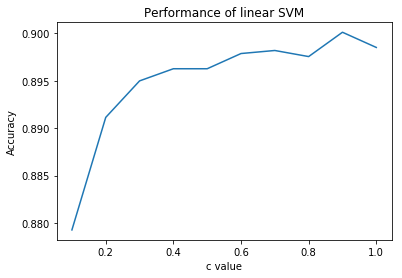

Best performing linear kernel SVM: C=0.9, Acc=0.9001310947443395


In [60]:
from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.svm import LinearSVC

num_fold = 5
k_fold = KFold(num_fold, True, 1)
kernel = 'linear'
acc = []
#     for coef_c in np.arange(1, 30, 10):
for c in np.arange(0.1, 1.1, 0.1):
    acc_arr = np.zeros(num_fold)
    ind = 0
    for train_rows, val_rows in k_fold.split(X_train):
#         model = svm.SVC(kernel=kernel, C=1, random_state=0)
        model = LinearSVC(random_state=0, C=c, loss='squared_hinge', dual=True)
        model.fit(X_train[train_rows], y_train[train_rows])
        pred_y = model.predict(X_train[val_rows])
        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
        ind += 1
    acc.append([c, np.mean(acc_arr)])
#         print("{}, c={}, Accuracy: {}".format(kernel, coef_c, acc[len(acc)-1][1]))
    print("{}, c={}, Accuracy: {}".format(kernel, c, acc[len(acc)-1][1]))
plt.plot([i[0] for i in acc], [i[1] for i in acc])
plt.title("Performance of {} SVM".format(kernel))
plt.xlabel("c value")
plt.ylabel("Accuracy")
# plt.savefig('../output/As1_Qn4.2_' + kernel + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
plt.show()
best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))

In [62]:
import xml.etree.ElementTree as ET
import csv


def get_susp_conv_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_predators_dict(file): 
    all_predators = {}
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            all_predators[row[0]] = 1
    return all_predators
            

def get_features_labels(root, labels_dict, all_predators):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        # only get suspicious conversations
        if labels_dict[conversation.get('id')] == '0':
            continue
        author_conv_dict = {}
        for message in conversation:
            author = message.find('author').text
            text = message.find('text').text
            if text is not None:
                if author not in author_conv_dict:
                    author_conv_dict[author] = text
                else:
                    author_conv_dict[author] += " " + text 
        for author, conv in author_conv_dict.items():
            corpus.append(conv)
            if author in all_predators:
                labels.append(1)
            else:
                labels.append(-1)
    return corpus, labels

In [ ]:
test_data_path = '../../data/svm_test_data/'
test_data_src = '../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

pred_test_file_path = '../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt'
test_corpus, test_labels = get_features_labels(test_root, get_susp_conv_dict(test_data_path), get_predators_dict(pred_test_file_path))

In [49]:
X_test = vectorizer.transform(test_corpus)

# print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))

# X_train = scipy.sparse.csr_matrix(X_train)
# y_train = np.array(labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

# print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))
# print("Training label shape: {}".format(y_train.shape))
print("Testing label shape: {}".format(y_test.shape))

Testing data shape: (5608, 11212)
Testing data shape: (5608, 11212)
Testing label shape: (5608,)


In [61]:
model = LinearSVC(random_state=0, C=best[0], loss='squared_hinge')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

ValueError: X has 11212 features per sample; expecting 11255